# From .FIT -> .csv

## How .FIT files are structured

``` FIT File = Header + Data Records + CRC ```

#### Record Messages
Location: `fit_data['record_mesgs']` - this is an array of timestamped data points

Frequency: Written every 1-2 seconds during activity recording

Contents:
- Standard data: timestamp, heart_rate, distance, speed, cadence
- Your custom sensor data: Appears as numbered fields (like 135: 176, 136: 73)
- GPS data: latitude, longitude, altitude (when available)

#### High Frequency Data
-  Accel/Gyro Data is Stored in Blocks (beacause of efficiency and different data rates )
- Instead of creating 25 separate record messages per second, Garmin batches them into arrays

#### What Data will look like

```python
# Low-frequency data = individual values per record
'record_mesgs': [{'timestamp': 16:46:14, 'heart_rate': 72}]

# High-frequency data = arrays of 25 values per batch    
'accelerometer_data_mesgs': [{                           
    'timestamp': 16:46:13,                               
    'calibrated_accel_x': [-298.09, -162.75, -271.42, ...], # 25 samples
    'sample_time_offset': [0, 19, 27, 39, 48, ...]          # Timing within batch
}]

```

In [4]:
from garmin_fit_sdk import Decoder, Stream
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
import numpy as np
import matplotlib.dates as mdates


####################
# For plotting on a map
import folium
from folium import plugins
###################

In [5]:
FIT_FILE_LOCATION = "/home/kuba/Desktop/test-garmin/wen-test/2025-06-17-09-39-31/2025-06-17-09-39-31.fit"#"/home/kuba/Desktop/2025-06-02-16-53-37a.fit"
FILE_NAME = 'test_recording'
CSV_SAVE_LOCATION = f"~/Desktop/{FILE_NAME}.csv"

In [6]:
stream = Stream.from_file(FIT_FILE_LOCATION)
decoder = Decoder(stream)
messages, errors = decoder.read()

In [7]:
print('errors: ',errors)

errors:  []


In [8]:
diff  = messages['record_mesgs'][-1]['timestamp'] - messages['record_mesgs'][0]['timestamp'] 
days = diff.days
hours = diff.seconds // 3600 
mins = (diff.seconds % 3600) // 60
secs = diff.seconds % 60

print(f" RECORDING LENGTH: {days:02}d {hours:02}h {mins:02}m {secs}s")

 RECORDING LENGTH: 00d 00h 00m 5s


In [9]:
gps_vaild = [1 if 'position_lat' in dic.keys() else 0 for dic in messages['record_mesgs']] # for each record mesg true if gps location recorded else false
total_mesgs = len(messages['record_mesgs'])

total_secs = (diff.days * 24 * 60 *60) + diff.seconds

print(f"{total_mesgs} record mesgs at {total_secs/total_mesgs:.1f} sec/record")
print(f"{sum(gps_vaild)} with GPS data at {(sum(gps_vaild) / total_mesgs)*100:.2f}% of all mesgs")

4 record mesgs at 1.2 sec/record
0 with GPS data at 0.00% of all mesgs


In [10]:
# messages

In [11]:
print('Accelerometer data we have ',len(messages['accelerometer_data_mesgs']),' groups of data')
print('Each group has ',len(messages['accelerometer_data_mesgs'][1]['calibrated_accel_x']),'sampled points')
print('In total we have',len(messages['accelerometer_data_mesgs']) * len(messages['accelerometer_data_mesgs'][1]['calibrated_accel_x']),'sampled points in the whole fit file')
print('\n','-'*60,'\n')
print('Gyroscope data we have ',len(messages['gyroscope_data_mesgs']),' groups of data')
print('Each group has ',len(messages['gyroscope_data_mesgs'][1]['calibrated_gyro_x']),'sampled points')
print('In total we have',len(messages['gyroscope_data_mesgs']) * len(messages['gyroscope_data_mesgs'][1]['calibrated_gyro_x']),'sampled points in the whole fit file')

Accelerometer data we have  68  groups of data
Each group has  25 sampled points
In total we have 1700 sampled points in the whole fit file

 ------------------------------------------------------------ 

Gyroscope data we have  68  groups of data
Each group has  25 sampled points
In total we have 1700 sampled points in the whole fit file


In [12]:
messages['record_mesgs'][-1]

{'timestamp': datetime.datetime(2025, 6, 17, 13, 39, 36, tzinfo=datetime.timezone.utc),
 'heart_rate': 74,
 135: 176,
 136: 74,
 'developer_fields': {0: 91.0}}

In [23]:
messages['file_id_mesgs'][0]['serial_number']

3504438977

In [13]:
#create the dataframeß
df_high_freq_data = pd.DataFrame(columns=['timestamp', 'x_accel', 'y_accel', 'z_accel', 'x_gyro', 'y_gyro', 'z_gyro'])
df_low_freq_data = pd.DataFrame(columns=['timestamp', 'position_lat', 'position_long', 'heart_rate'])
df_event_self_reports = pd.DataFrame(columns=['start_timestamp', 'end_timestamp', 'event_type'])

In [14]:
# add a group to the dataframe
def add_to_df_high_freq_data(df, x_accel, y_accel, z_accel, x_gyro, y_gyro, z_gyro, timestamp, timestamp_ms, sample_time_offset):
    if not (len(x_accel) == len(y_accel) == len(z_accel) == len(sample_time_offset)) or not (len(x_gyro) == len(y_gyro) == len(z_gyro) == len(sample_time_offset)) or not (len(x_accel) == len(x_gyro)):
        raise ValueError("All input lists must have the same length")

    
    precise_base_timestamp = timestamp.replace(microsecond=timestamp_ms*1000)
    
    start_idx = len(df)
    
    for i in range(len(x_gyro)):
        sample_timestamp = precise_base_timestamp + datetime.timedelta(milliseconds=sample_time_offset[i])
        df.loc[start_idx + i] = [sample_timestamp, x_accel[i], y_accel[i], z_accel[i], x_gyro[i], y_gyro[i], z_gyro[i]]
    
    return df

In [15]:
# # iterate over all groups to add to the df
# for group in tqdm(range(len(messages['accelerometer_data_mesgs']))):
#     df_high_freq_data = add_to_df_high_freq_data(df_high_freq_data, 
#                    messages['accelerometer_data_mesgs'][group]['calibrated_accel_x'], 
#                    messages['accelerometer_data_mesgs'][group]['calibrated_accel_y'], 
#                    messages['accelerometer_data_mesgs'][group]['calibrated_accel_z'],

#                    messages['gyroscope_data_mesgs'][group]['calibrated_gyro_x'], 
#                    messages['gyroscope_data_mesgs'][group]['calibrated_gyro_y'], 
#                    messages['gyroscope_data_mesgs'][group]['calibrated_gyro_z'],
                   
#                    messages['accelerometer_data_mesgs'][group]['timestamp'], 
#                    messages['accelerometer_data_mesgs'][group]['timestamp_ms'], 

#                    messages['accelerometer_data_mesgs'][group]['sample_time_offset'])

In [16]:
vaild_event_types = {1, 2}
def process_self_reports(timestamp, event_type, df_event_self_reports, is_event_active, is_event_active_Field):
    if event_type in vaild_event_types:

        if (not is_event_active) and (is_event_active_Field == 1): #just switched the event on
            df_event_self_reports = pd.concat([df_event_self_reports, pd.DataFrame([{'start_timestamp': timestamp, 'end_timestamp': pd.NA, 'event_type':event_type}])], ignore_index=True )
            is_event_active =  True

        elif (is_event_active) and (is_event_active_Field == 0): #jsut switched the even off
            df_event_self_reports.at[df_event_self_reports.index[-1], 'end_timestamp'] = timestamp
            is_event_active = False

    return df_event_self_reports, is_event_active

In [17]:
is_event_active = False
for mesg in messages['record_mesgs']:
    position_lat = mesg['position_lat'] if 'position_lat' in mesg.keys() else np.nan
    position_long = mesg['position_long'] if 'position_lat' in mesg.keys() else np.nan
    heart_rate = mesg['heart_rate'] if 'heart_rate' in mesg.keys() else np.nan
    battery = mesg['developer_fields'][0]

    df_low_freq_data = pd.concat([df_low_freq_data, pd.DataFrame([{'timestamp': mesg['timestamp'], 'position_lat':position_lat, 'position_long':position_long, 'heart_rate':heart_rate, 'battery':battery}])], ignore_index=True )

    is_event_active_Field =  mesg['developer_fields'][1] #is_event_active_Field this valie is one if we are recroding and anythin else if we are not recording
    event_type = mesg['developer_fields'][2] # event type
    df_event_self_reports, is_event_active = process_self_reports(mesg['timestamp'], event_type, df_event_self_reports, is_event_active, is_event_active_Field)

df_low_freq_data['timestamp'] = df_low_freq_data['timestamp'].dt.tz_convert('US/Eastern')

/tmp/ipykernel_22695/1368032208.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_low_freq_data = pd.concat([df_low_freq_data, pd.DataFrame([{'timestamp': mesg['timestamp'], 'position_lat':position_lat, 'position_long':position_long, 'heart_rate':heart_rate, 'battery':battery}])], ignore_index=True )


KeyError: 1

In [ ]:
messages['record_mesgs'][-1]

{'timestamp': datetime.datetime(2025, 6, 17, 19, 14, 9, tzinfo=datetime.timezone.utc),
 'enhanced_respiration_rate': 14.0,
 'current_stress': 99.0,
 'heart_rate': 114,
 135: 136,
 136: 114,
 143: 47,
 'developer_fields': {0: 100.0, 1: 0, 2: 1}}

In [ ]:
df_event_self_reports

,start_timestamp,end_timestamp,event_type
0,2025-06-17 19:09:18+00:00,2025-06-17 19:09:38+00:00,1
1,2025-06-17 19:09:54+00:00,2025-06-17 19:10:01+00:00,2
2,2025-06-17 19:13:54+00:00,2025-06-17 19:13:57+00:00,1


Text(0, 0.5, 'Battery %')

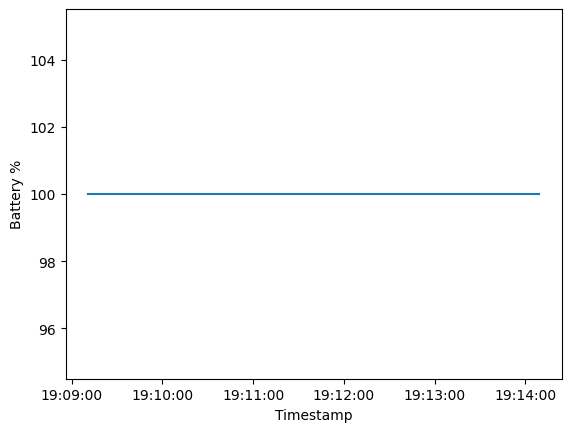

In [ ]:
plt.plot(df_low_freq_data['timestamp'],df_low_freq_data['battery'])

time_formatter = mdates.DateFormatter('%H:%M:%S')  # Format as HH:MM:SS
plt.gca().xaxis.set_major_formatter(time_formatter)

plt.xlabel("Timestamp")
plt.ylabel("Battery %")

In [ ]:
df_high_freq_data.tail(50)

,timestamp,x_accel,y_accel,z_accel,x_gyro,y_gyro,z_gyro


In [ ]:
(df_high_freq_data.iloc[8152]['timestamp']).tz_convert('America/New_York')

IndexError: single positional indexer is out-of-bounds

In [ ]:


conversion_factor = 180 / (2**31)
df_low_freq_data['lat'] = df_low_freq_data['position_lat'] * conversion_factor
df_low_freq_data['lon'] = df_low_freq_data['position_long'] * conversion_factor

# Convert timestamp to datetime
df_low_freq_data['timestamp'] = pd.to_datetime(df_low_freq_data['timestamp'])

print(f"Original dataset size: {len(df_low_freq_data)} rows")
df_clean = df_low_freq_data.dropna(subset=['lat', 'lon', 'heart_rate']).copy()
print(f"After removing NaN values: {len(df_clean)} rows")

def create_gps_map(df):
    """
    Create an interactive map showing GPS tracking data with heart rate information
    """
    
    # Calculate center point for the map
    center_lat = df['lat'].mean()
    center_lon = df['lon'].mean()
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=18,  # High zoom for detailed view
        tiles='OpenStreetMap'
    )
    
    # Create a color map for heart rate (green = low, red = high)
    def get_color(heart_rate):
        if heart_rate < 60:
            return 'green'
        elif heart_rate < 80:
            return 'orange'
        else:
            return 'red'
    
    # Add markers for each GPS point
    for idx, row in df.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5,
            popup=f"""
            <b>Time:</b> {row['timestamp'].strftime('%H:%M:%S')}<br>
            <b>Heart Rate:</b> {row['heart_rate']} bpm<br>
            <b>Coordinates:</b> {row['lat']:.6f}, {row['lon']:.6f}
            """,
            color=get_color(row['heart_rate']),
            fillColor=get_color(row['heart_rate']),
            fillOpacity=0.8,
            weight=2
        ).add_to(m)
    
    # Create the path line
    coordinates = [[row['lat'], row['lon']] for _, row in df.iterrows()]
    folium.PolyLine(
        coordinates,
        color='blue',
        weight=3,
        opacity=0.8
    ).add_to(m)
    
    # Add start and end markers
    folium.Marker(
        location=[df.iloc[0]['lat'], df.iloc[0]['lon']],
        popup='Start',
        icon=folium.Icon(color='green', icon='play')
    ).add_to(m)
    
    folium.Marker(
        location=[df.iloc[-1]['lat'], df.iloc[-1]['lon']],
        popup='End',
        icon=folium.Icon(color='red', icon='stop')
    ).add_to(m)
    
    # Add a legend
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 150px; height: 90px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <p><b>Heart Rate Legend</b></p>
    <p><i class="fa fa-circle" style="color:green"></i> < 60 bpm</p>
    <p><i class="fa fa-circle" style="color:orange"></i> 60-80 bpm</p>
    <p><i class="fa fa-circle" style="color:red"></i> > 80 bpm</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# Create and display the map
map_obj = create_gps_map(df_clean)
display(map_obj)

Original dataset size: 798 rows
After removing NaN values: 202 rows


Lets take a look at it

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df_high_freq_data['x_accel'], label='x_accel')
plt.plot(df_high_freq_data['y_accel'], label='y_accel')
plt.plot(df_high_freq_data['z_accel'], label='z_accel')

plt.plot(df_high_freq_data['x_gyro'], label='x_gyro')
plt.plot(df_high_freq_data['y_gyro'], label='y_gyro')
plt.plot(df_high_freq_data['z_gyro'], label='z_gyro')
plt.legend()
plt.show()


Now lests save it

In [ ]:
df.to_csv(CSV_SAVE_LOCATION, index=False)